In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import optuna 
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")

test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")

sample_sub = pd.read_csv("/kaggle/input/playground-series-s4e2/sample_submission.csv")

In [3]:
test2 = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")

In [4]:
print("train dimension is : ",train.shape)
print("test dimension is :",test.shape)

train dimension is :  (20758, 18)
test dimension is : (13840, 17)


In [5]:
target ='NObeyesdad'

In [6]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [7]:
train.drop('id',axis=1,inplace=True)

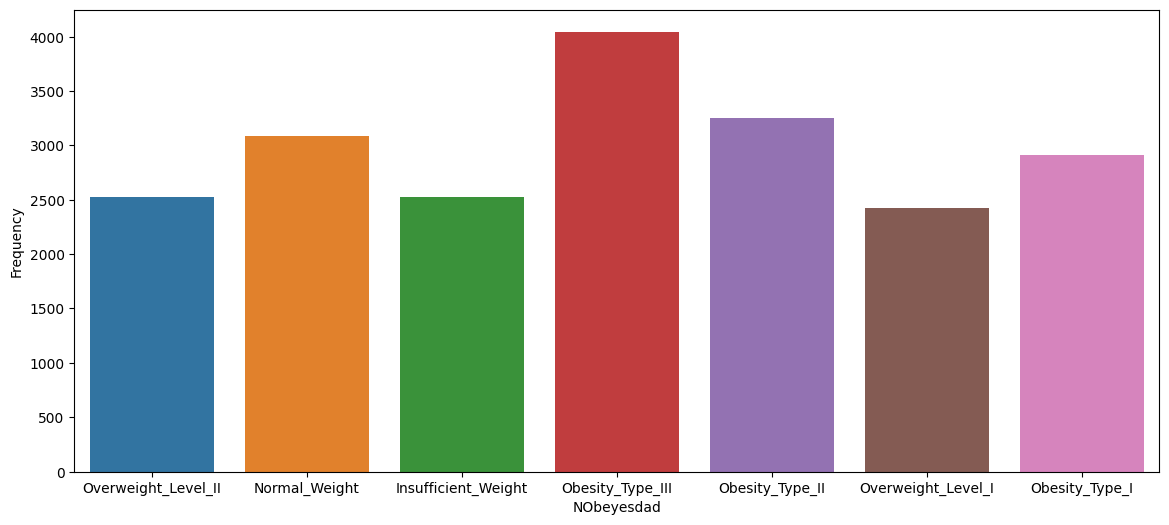

In [8]:
plt.figure(figsize=(14, 6)) 
sns.countplot(data = train, x = 'NObeyesdad')
plt.ylabel('Frequency');

In [9]:
train.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [10]:
categorical_feats = []

for column in train.columns :
    if train[column].dtype == 'object':
        categorical_feats.append(column)
        
print(categorical_feats) 

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [11]:
numerical_feats = []

for column in train.columns :
    if train[column].dtype != 'object':
        numerical_feats.append(column)
        
print(numerical_feats) 

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


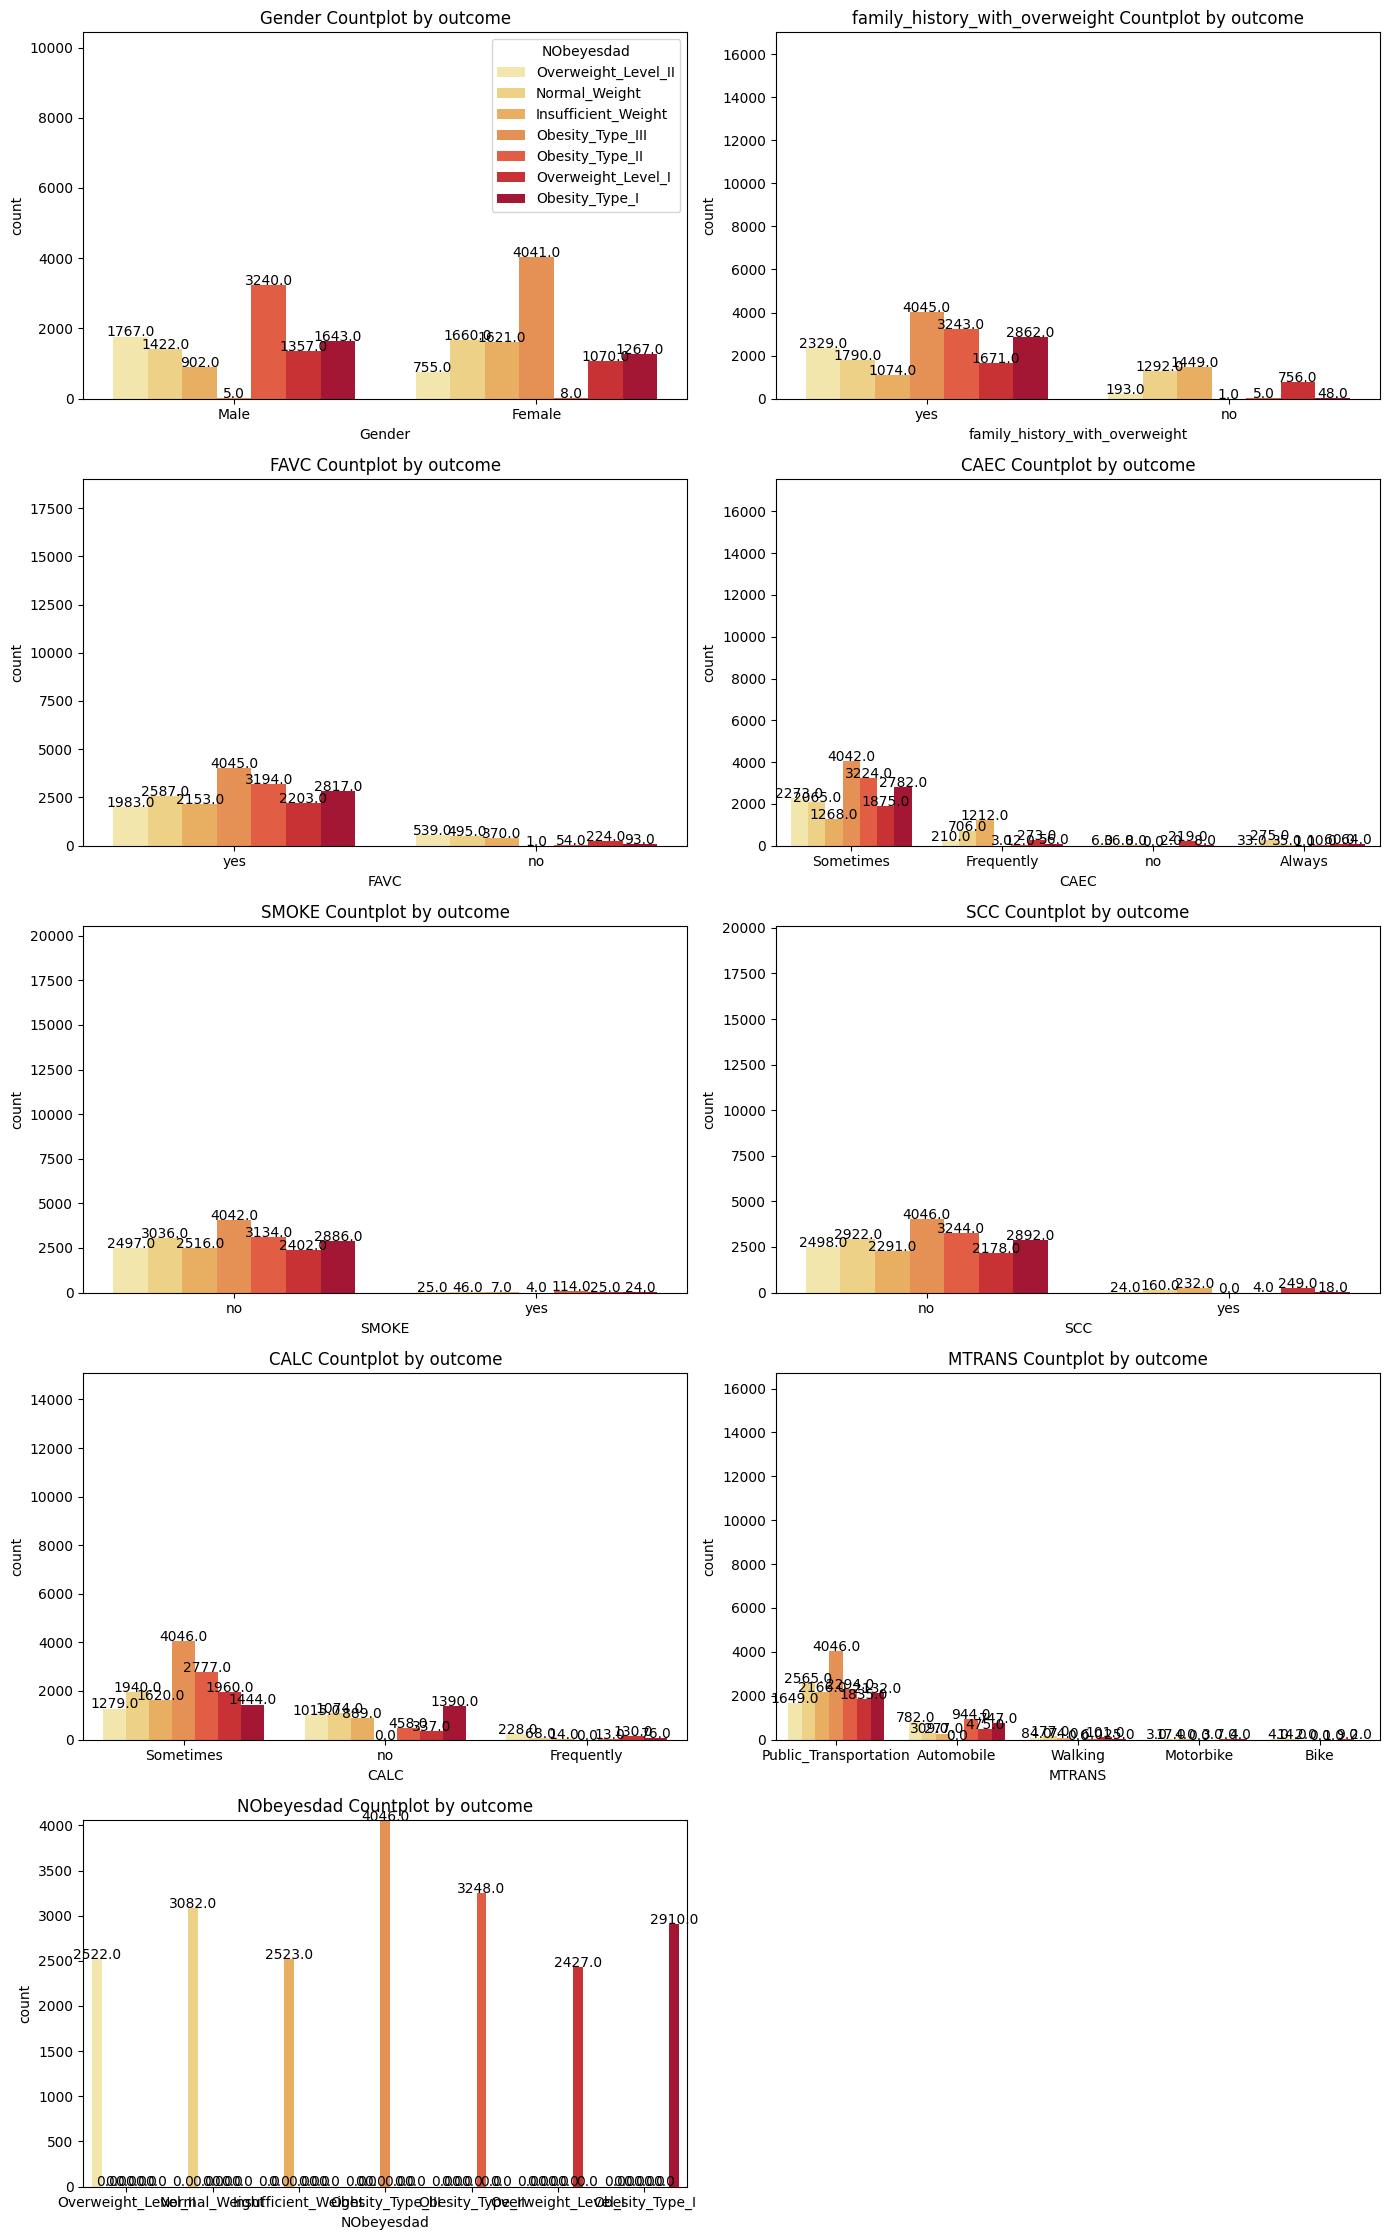

In [12]:
plt.figure(figsize=(14, len(categorical_feats)*2.5))

for idx, column in enumerate(categorical_feats):
    plt.subplot(len(categorical_feats)//2 + len(categorical_feats) % 2, 2, idx+1)
    ax = sns.countplot(x=column, data=train, hue='NObeyesdad', palette='YlOrRd')
    plt.title(f"{column} Countplot by outcome")
    plt.ylim(0, train[column].value_counts().max() + 10)

    for p in ax.patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width()/2., height + 2, height, ha="center")

    # Remove duplicate legend
    if idx != 0:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

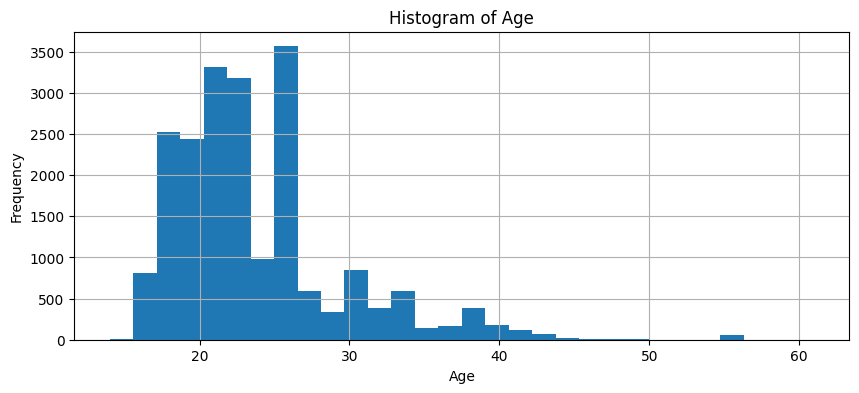

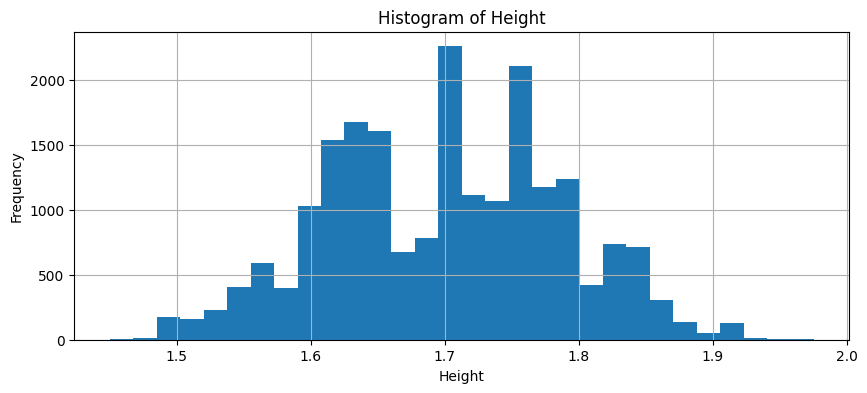

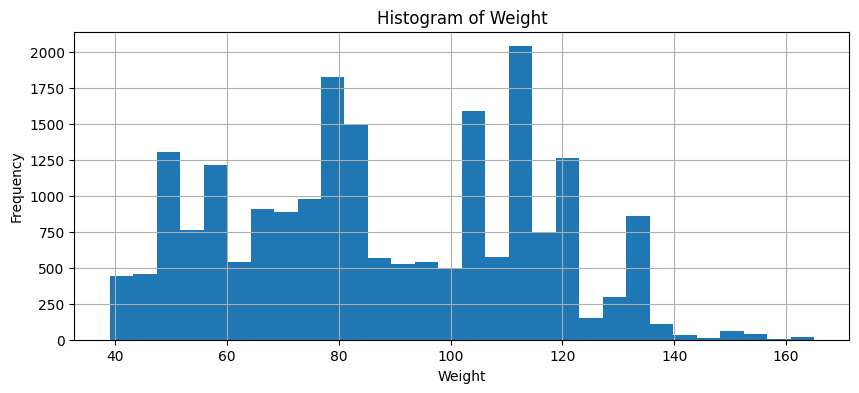

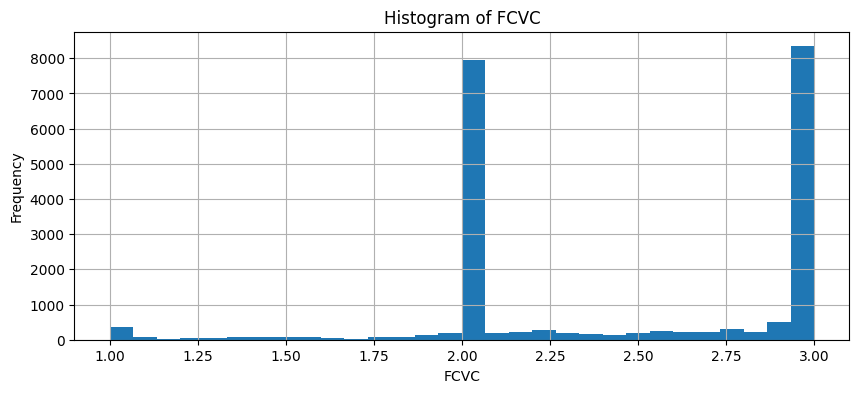

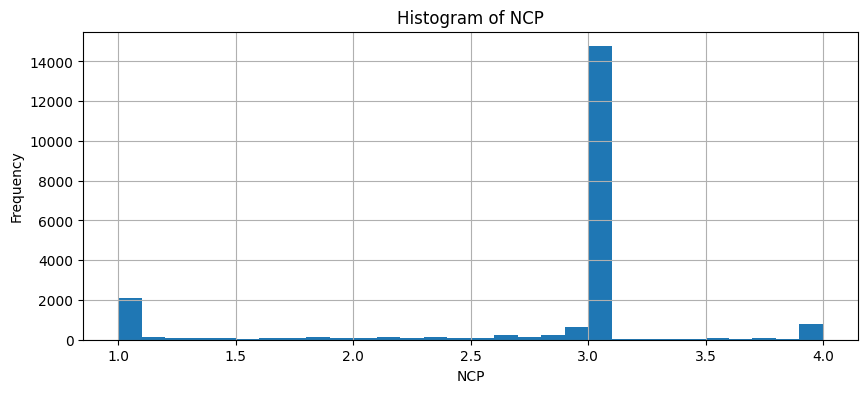

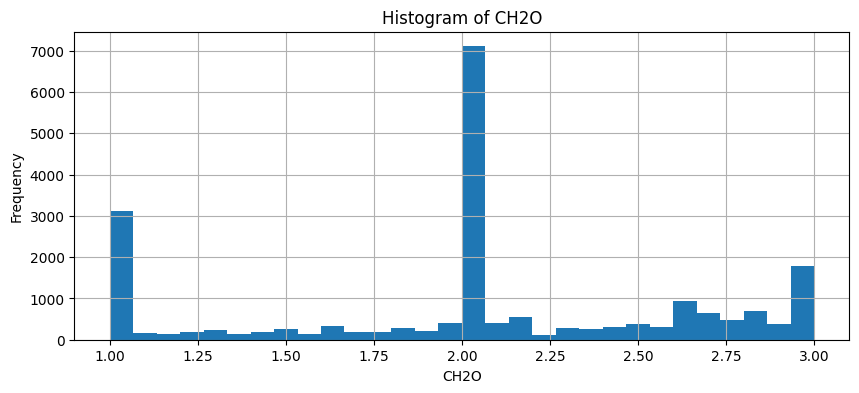

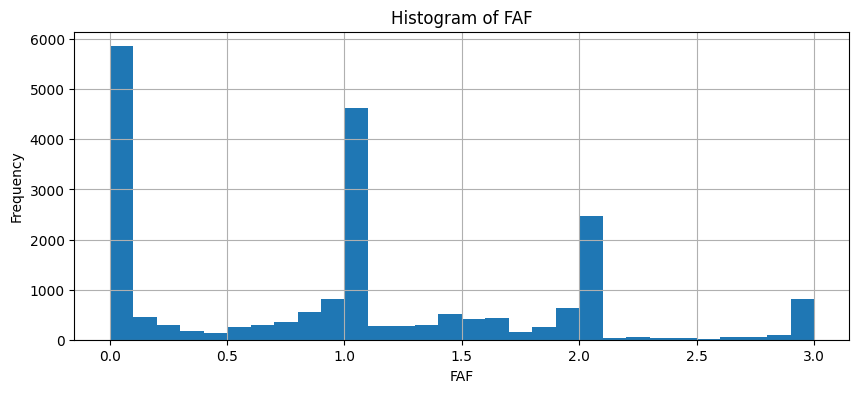

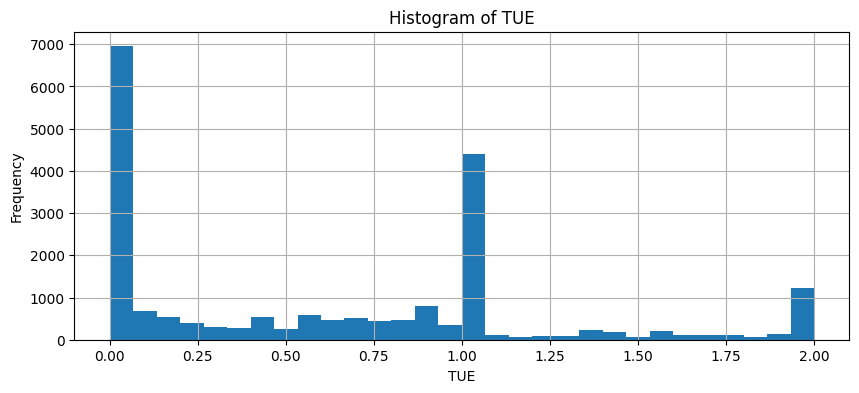

In [13]:
for feature in numerical_feats:
    plt.figure(figsize=(10, 4))
    train[feature].hist(bins=30)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature}')
    plt.show()

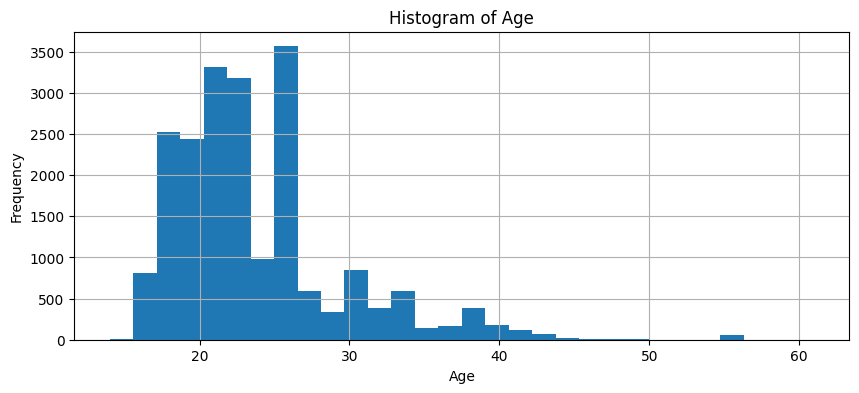

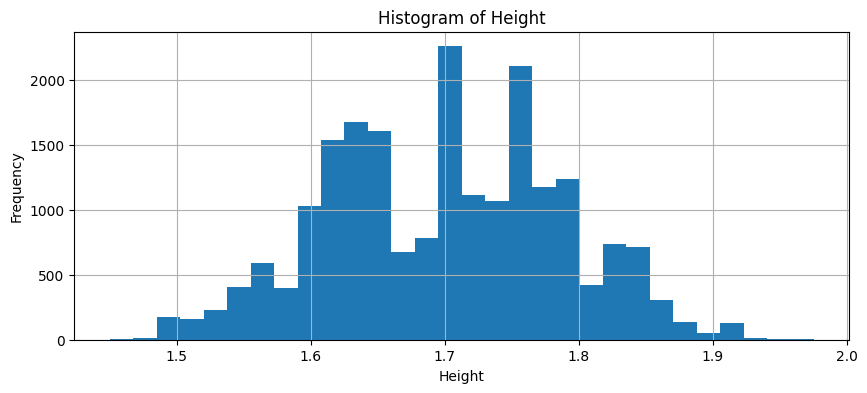

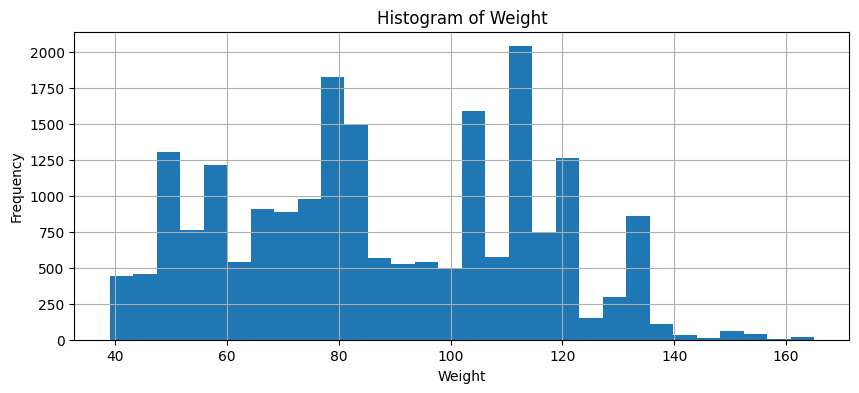

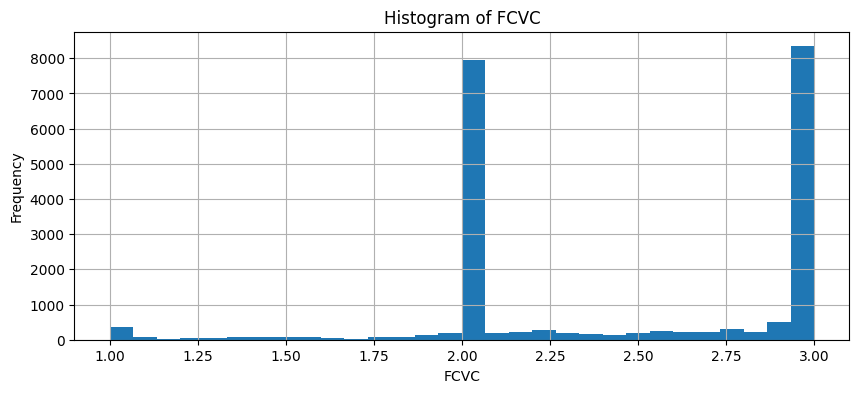

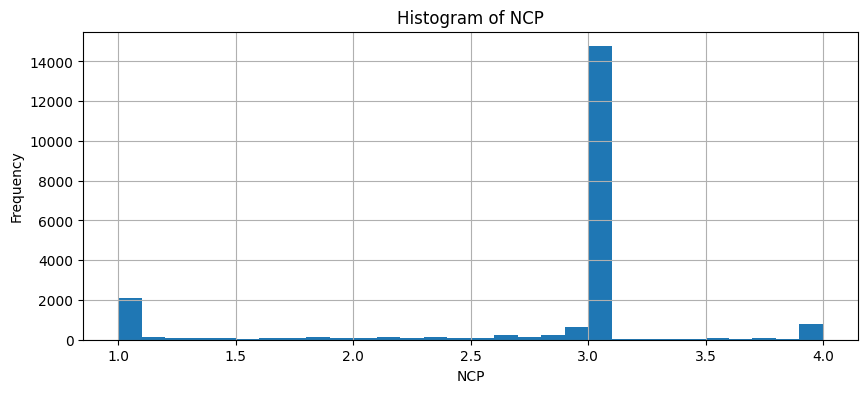

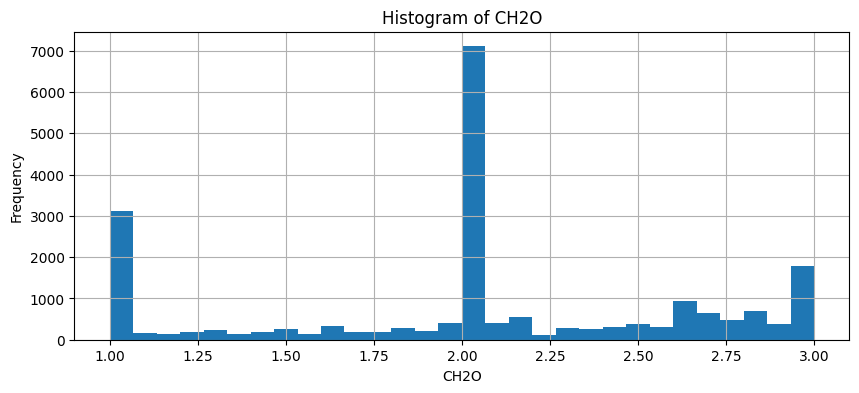

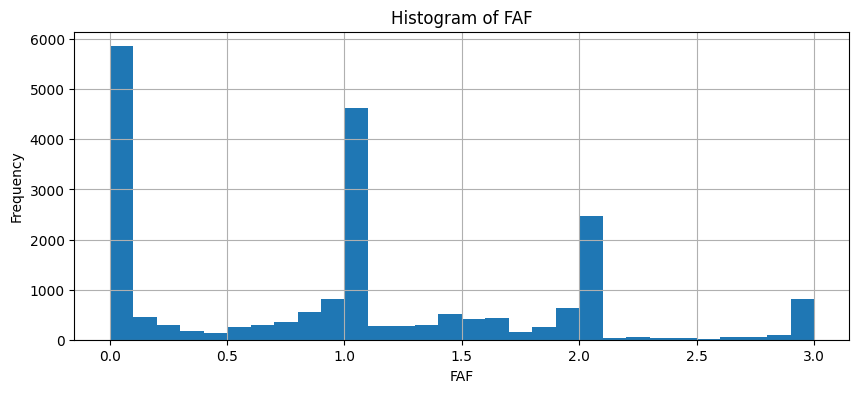

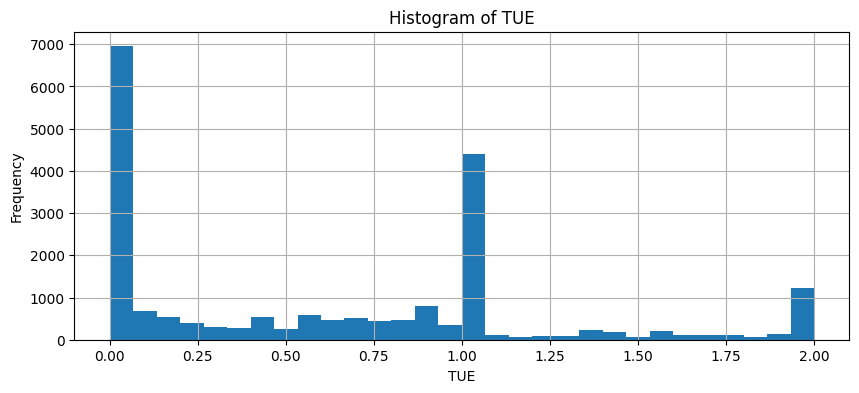

In [14]:
for feature in numerical_feats:
    plt.figure(figsize=(10, 4))
    train[feature].hist(bins=30)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature}')
    plt.show()

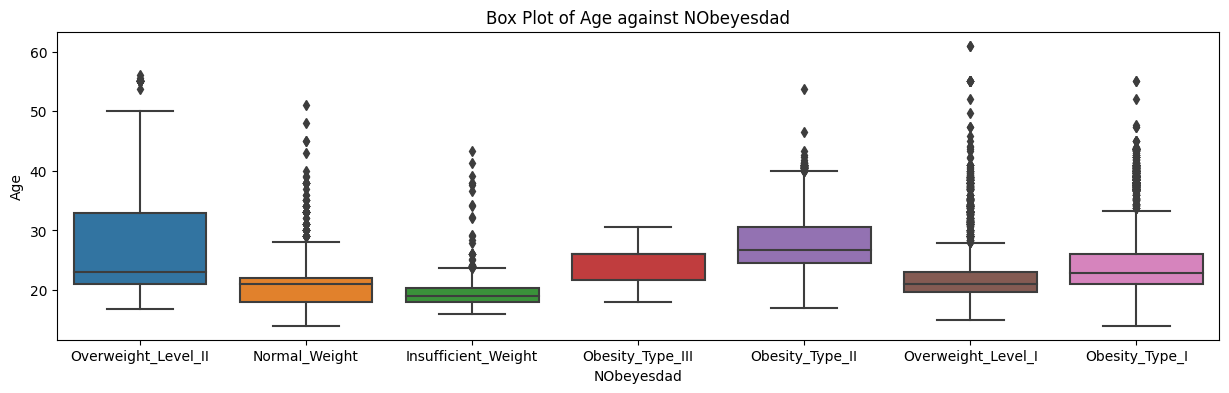

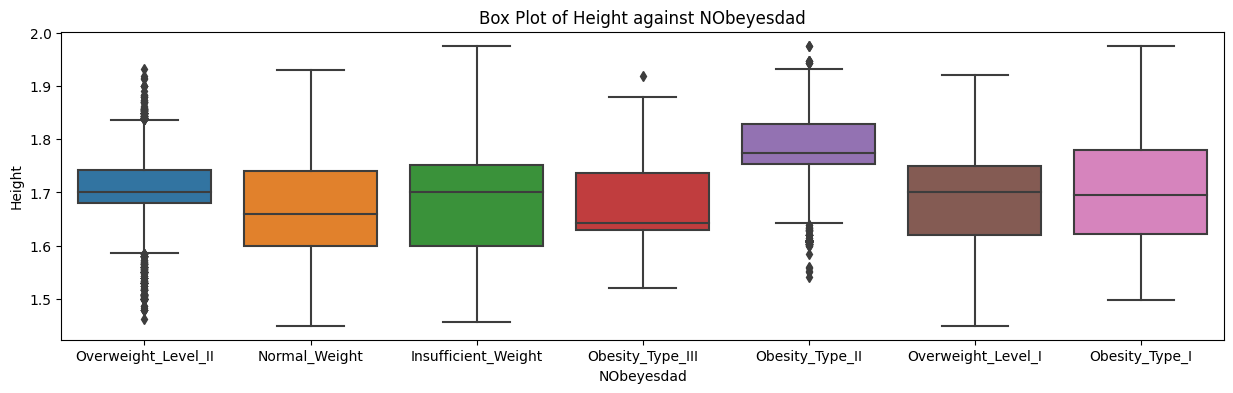

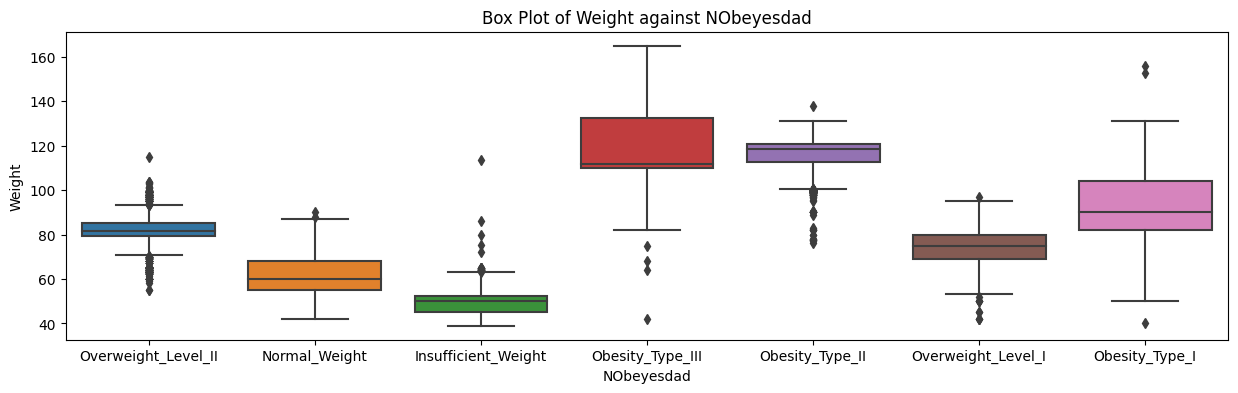

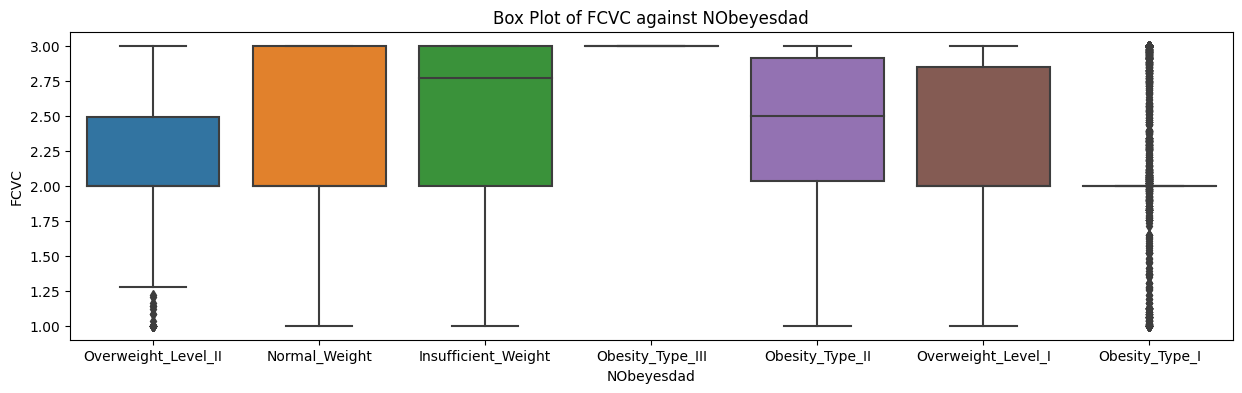

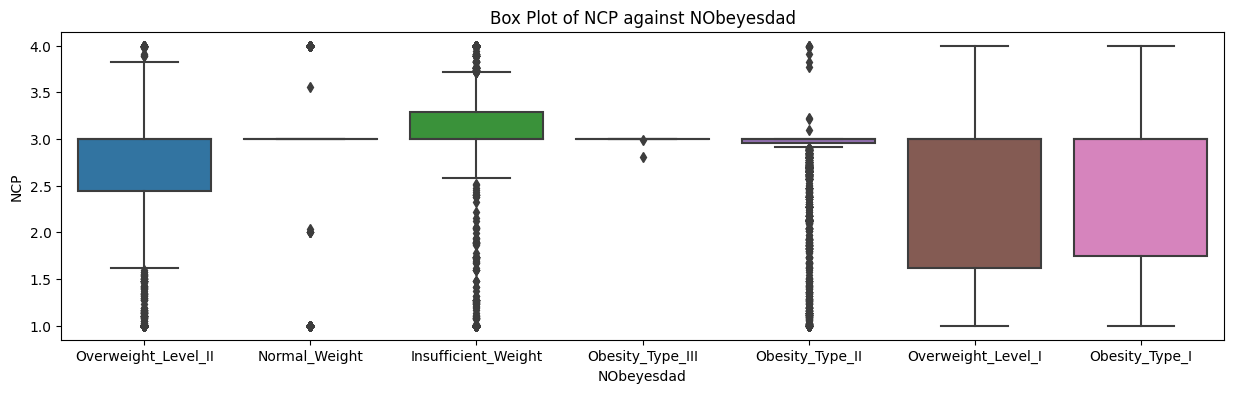

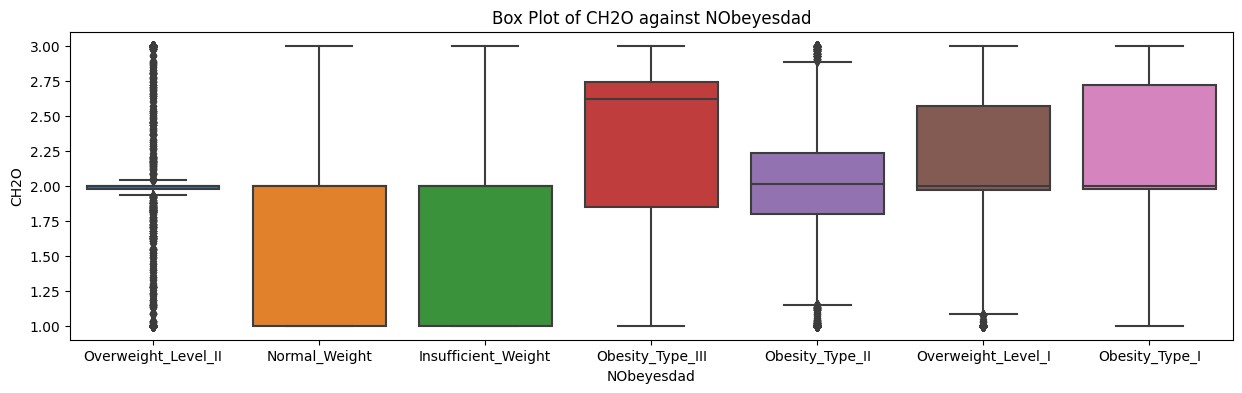

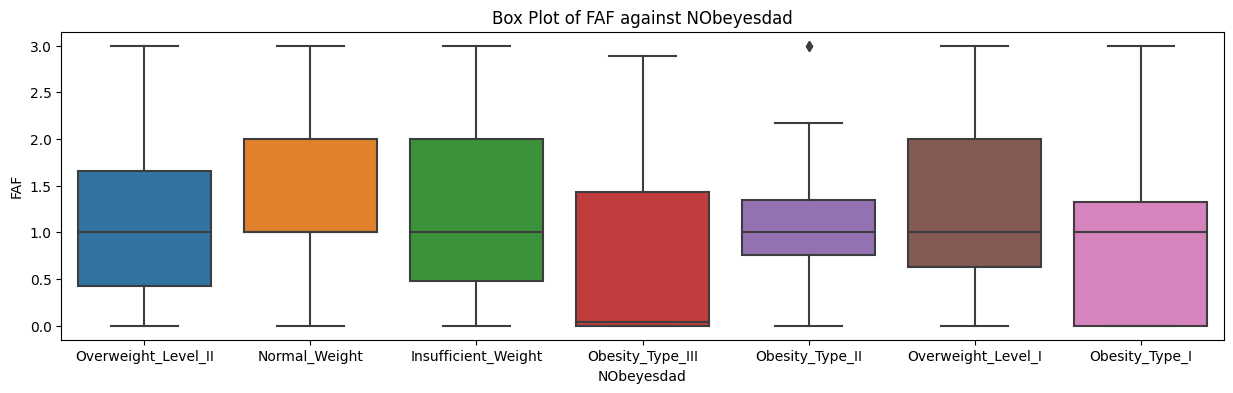

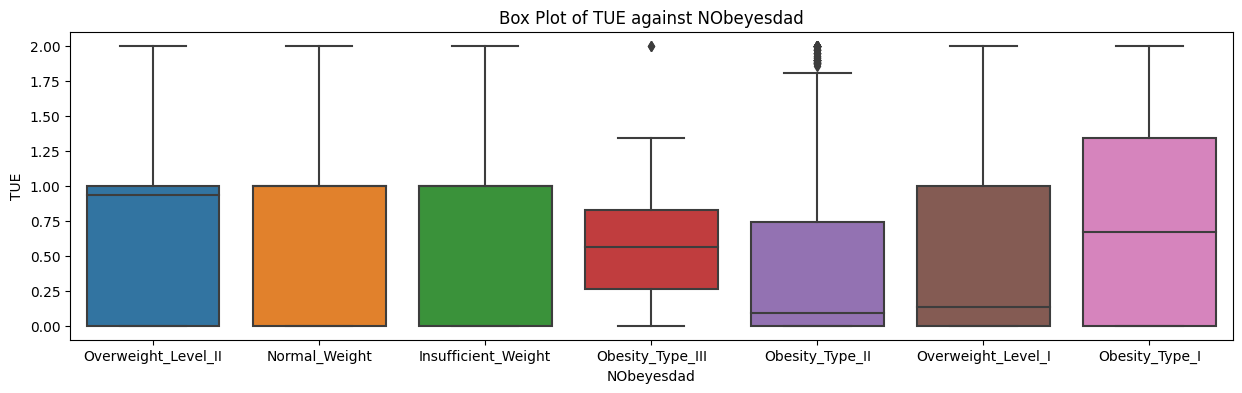

In [15]:
for feature in numerical_feats:
    plt.figure(figsize=(15, 4))
    sns.boxplot(x=target, y=feature, data=train)
    plt.title(f'Box Plot of {feature} against {target}')
    plt.show()

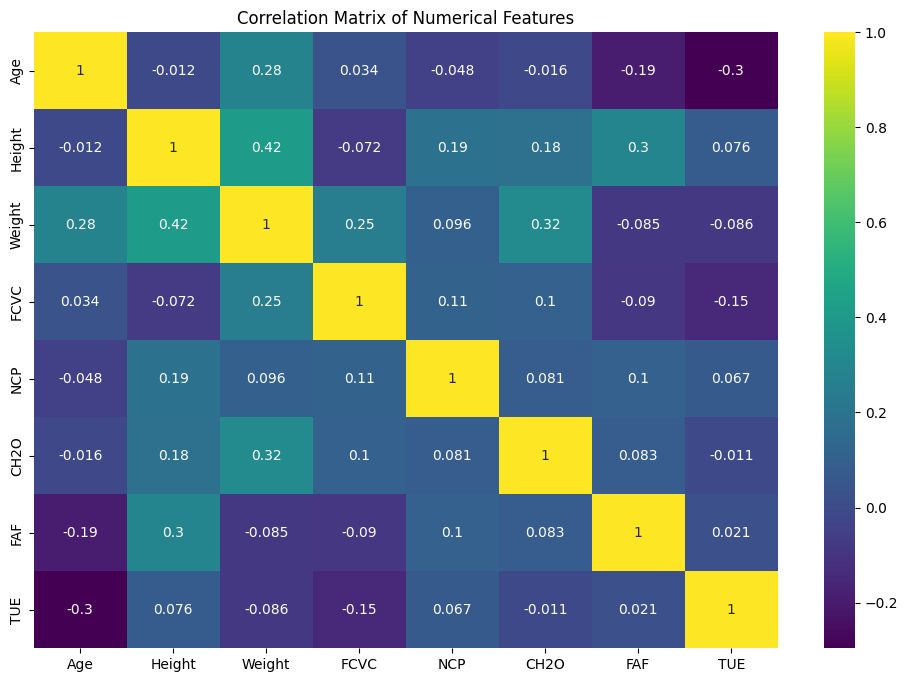

In [16]:
corr_matrix = train[numerical_feats].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [17]:
def bmi_category(row):
    bmi = row['Weight'] / (row['Height'] ** 2)  
   
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Healthy weight"
    elif 25 <= bmi < 30:
        return "Overweight"
    elif 30 <= bmi < 35:
        return "Obesity (Class 1)"
    elif 35 <= bmi < 40:
        return "Obesity (Class 2)"
    else:
        return "Obesity (Class 3)"

train['bmi_category'] = train.apply(bmi_category, axis=1)
test['bmi_category'] = test.apply(bmi_category, axis=1)

In [18]:
train['bmi_category'].head(10)

0           Overweight
1       Healthy weight
2          Underweight
3    Obesity (Class 3)
4           Overweight
5          Underweight
6    Obesity (Class 2)
7    Obesity (Class 2)
8       Healthy weight
9    Obesity (Class 3)
Name: bmi_category, dtype: object

In [19]:
bmi_mapping = {
    "Underweight": 0,
    "Healthy weight": 1,
    "Overweight": 2,
    "Obesity (Class 1)": 3,
    "Obesity (Class 2)": 4,
    "Obesity (Class 3)": 5
}

train['bmi_category_encoded'] = train['bmi_category'].map(bmi_mapping)
test['bmi_category_encoded'] = test['bmi_category'].map(bmi_mapping)
train = train.drop(columns='bmi_category')
test = test.drop(columns='bmi_category')

In [20]:
train['bmi_category_encoded'].head(10)

0    2
1    1
2    0
3    5
4    2
5    0
6    4
7    4
8    1
9    5
Name: bmi_category_encoded, dtype: int64

In [21]:
train['age_faf'] = train['Age'] * train['FAF']
test['age_faf'] = test['Age'] * test['FAF']

In [22]:
def calculate_lifestyle_score(row):
    favc_score = 0 if row['FAVC'] == 'No' else 1  
    fcvc_score = row['FCVC']  
    faf_score = row['FAF']  
    tue_score = 1 if row['TUE'] > 2 else 0 
    return favc_score - fcvc_score + tue_score - faf_score

train['lifestyle_score'] = train.apply(calculate_lifestyle_score, axis=1)
test['lifestyle_score'] = test.apply(calculate_lifestyle_score, axis=1)

In [23]:
def calculate_health_awareness_score(row):
    scc_score = 0 if row['SCC'] == 'No' else 1  
    ch2o_score = row['CH2O']  
    smoke_score = 1 if row['SMOKE'] == 'yes' else 0 
    return scc_score + ch2o_score + smoke_score


train['health_awareness_score'] = train.apply(calculate_health_awareness_score, axis=1)
test['health_awareness_score'] = test.apply(calculate_health_awareness_score, axis=1)

In [24]:
train['NObeyesdad'].values

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight', ...,
       'Obesity_Type_II', 'Overweight_Level_II', 'Obesity_Type_II'],
      dtype=object)

In [25]:
y_train = train["NObeyesdad"].map({'Normal_Weight':0,'Insufficient_Weight':1,'Overweight_Level_I':2 ,'Overweight_Level_II':3,'Obesity_Type_I':4 ,'Obesity_Type_II':5
                                  ,'Obesity_Type_III':6})

In [26]:
categorical_feats.remove('NObeyesdad')

In [27]:
numerical_featstrain = []

for column in train.columns :
    if train[column].dtype != 'object':
        numerical_featstrain.append(column)
        
print(numerical_featstrain) 

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'bmi_category_encoded', 'age_faf', 'lifestyle_score', 'health_awareness_score']


In [28]:
train['Gender'] = train['Gender'].map({'Female':0, 'Male':1})
train['SMOKE'] = train['SMOKE'].map({'no':0, 'yes':1})
train['SCC'] = train['SCC'].map({'no':0, 'yes':1})
train['CALC'] = train['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
train['FAVC'] = train['FAVC'].map({'no':0, 'yes':1})
train['family_history_with_overweight'] = train['family_history_with_overweight'].map({'no':0, 'yes':1})
train['CAEC'] = train['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
train['MTRANS'] = train['MTRANS'].map({'Bike':0,'Walking':1,'Motorbike':2,'Public_Transportation':3,'Automobile':4})

In [29]:
numerical_featstest = []

for column in test.columns :
    if test[column].dtype != 'object':
        numerical_featstest.append(column)
        
print(numerical_featstest) 

['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'bmi_category_encoded', 'age_faf', 'lifestyle_score', 'health_awareness_score']


In [30]:
test['MTRANS'].value_counts()

MTRANS
Public_Transportation    11111
Automobile                2405
Walking                    280
Bike                        25
Motorbike                   19
Name: count, dtype: int64

In [31]:
test['Gender'] = test['Gender'].map({'Female':0, 'Male':1})
test['SMOKE'] = test['SMOKE'].map({'no':0, 'yes':1})
test['SCC'] = test['SCC'].map({'no':0, 'yes':1})
test['CALC'] = test['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
test['FAVC'] = test['FAVC'].map({'no':0, 'yes':1})
test['family_history_with_overweight'] = test['family_history_with_overweight'].map({'no':0, 'yes':1})
test['CAEC'] = test['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
test['MTRANS'] = test['MTRANS'].map({'Bike':0,'Walking':1,'Motorbike':2,'Public_Transportation':3,'Automobile':4})

In [32]:
scaler = StandardScaler()

train[numerical_featstrain] = scaler.fit_transform(train[numerical_featstrain])

In [33]:
test.drop('id',axis=1,inplace=True)

In [34]:
numerical_featstest.remove('id')

In [35]:
scaler = StandardScaler()

test[numerical_featstest] = scaler.fit_transform(test[numerical_featstest])

In [36]:
X = train
y = y_train.astype(int)

In [37]:
X.drop('NObeyesdad',axis=1,inplace=True)

In [38]:
from sklearn.feature_selection import SelectKBest,  f_classif

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

def objective(trial):
    param = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1),
    }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dval)
    pred_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_trial = study.best_trial

print('Number of finished trials:', len(study.trials))
print('Best trial:', best_trial.params)

[I 2024-02-18 13:32:19,698] A new study created in memory with name: no-name-ef381d36-ebfa-49da-91bd-64bdb61518e3
[I 2024-02-18 13:32:19,873] Trial 0 finished with value: 0.835019267822736 and parameters: {'max_depth': 4, 'eta': 1.3724183809286328e-08, 'gamma': 1.1238138089694012e-08, 'subsample': 0.22034994642822983, 'colsample_bytree': 0.6358583595448617}. Best is trial 0 with value: 0.835019267822736.
[I 2024-02-18 13:32:20,006] Trial 1 finished with value: 0.867533718689788 and parameters: {'max_depth': 4, 'eta': 1.3088461675802675e-06, 'gamma': 1.0212326208785444e-05, 'subsample': 0.24080830207949566, 'colsample_bytree': 0.48782430576714975}. Best is trial 1 with value: 0.867533718689788.
[I 2024-02-18 13:32:20,104] Trial 2 finished with value: 0.8427263969171483 and parameters: {'max_depth': 2, 'eta': 6.828412098331259e-05, 'gamma': 1.244411108616401e-08, 'subsample': 0.25331699725238993, 'colsample_bytree': 0.40296964243824734}. Best is trial 1 with value: 0.867533718689788.
[I 

Number of finished trials: 100
Best trial: {'max_depth': 6, 'eta': 0.4530155689065658, 'gamma': 1.0156044174518449e-07, 'subsample': 0.8364275726359653, 'colsample_bytree': 0.7805989695109028}


In [41]:
best_params = best_trial.params
best_params.update({
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y))
})

bst = xgb.train(best_params, dtrain)

In [42]:
dtest = xgb.DMatrix(test)
preds = bst.predict(dtest)
pred_labels = np.argmax(preds, axis=1)

In [43]:
submission = pd.DataFrame({'id': test2['id'], 'NObeyesdad': pred_labels})


label_map = {
    0: 'Normal_Weight',
    1: 'Insufficient_Weight',
    2: 'Overweight_Level_I',
    3: 'Overweight_Level_II',
    4: 'Obesity_Type_I',
    5: 'Obesity_Type_II',
    6: 'Obesity_Type_III',
  
}

submission['NObeyesdad'] = submission['NObeyesdad'].map(label_map)


submission.to_csv('xgb.csv', index=False)

In [44]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

def lgb_objective(trial):
    lgb_param = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter': False,
    }

    lgb_model = lgb.train(lgb_param, lgb_train, num_boost_round=100, valid_sets=[lgb_val])
    preds = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    pred_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_objective, n_trials=100)

lgb_best_trial = lgb_study.best_trial

print('Number of finished trials:', len(lgb_study.trials))
print('Best trial:', lgb_best_trial.params)

lgb_best_params = lgb_best_trial.params
lgb_best_params.update({
    'objective': 'multiclass',
    'num_class': len(np.unique(y))
})

lgb_bst = lgb.train(lgb_best_params, lgb_train)

lgb_preds = lgb_bst.predict(test)
lgb_pred_labels = np.argmax(lgb_preds, axis=1)

submission_lgb = pd.DataFrame({'id': test2['id'], 'NObeyesdad': lgb_pred_labels})
submission_lgb['NObeyesdad'] = submission_lgb['NObeyesdad'].map(label_map)
submission_lgb.to_csv('lgb.csv', index=False)

[I 2024-02-18 13:32:45,229] A new study created in memory with name: no-name-21409785-b4b0-482d-972b-7da2a028fe7d
[I 2024-02-18 13:32:52,267] Trial 0 finished with value: 0.9067919075144508 and parameters: {'lambda_l1': 3.819223896937865, 'lambda_l2': 6.088933962281497e-08, 'num_leaves': 240, 'feature_fraction': 0.6003765588141392, 'bagging_fraction': 0.5872179049013628, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 0 with value: 0.9067919075144508.
[I 2024-02-18 13:33:02,290] Trial 1 finished with value: 0.9036608863198459 and parameters: {'lambda_l1': 2.635625877942072e-08, 'lambda_l2': 2.8746322085586504, 'num_leaves': 86, 'feature_fraction': 0.6266124175107215, 'bagging_fraction': 0.6401836162232378, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 0 with value: 0.9067919075144508.
[I 2024-02-18 13:33:05,951] Trial 2 finished with value: 0.9053468208092486 and parameters: {'lambda_l1': 0.3146623488482442, 'lambda_l2': 0.18691910932868797, 'num_leaves': 11, 'f

Number of finished trials: 100
Best trial: {'lambda_l1': 1.0772451579667284, 'lambda_l2': 2.699474876957792e-08, 'num_leaves': 122, 'feature_fraction': 0.7047917035976026, 'bagging_fraction': 0.6622122385627378, 'bagging_freq': 4, 'min_child_samples': 72}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2791
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 20
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [W

In [45]:
xgb_preds = bst.predict(dtest)
lgb_preds = lgb_bst.predict(test)

avg_preds = (xgb_preds + lgb_preds) / 2

avg_pred_labels = np.argmax(avg_preds, axis=1)

submission_avg = pd.DataFrame({'id': test2['id'], 'NObeyesdad': avg_pred_labels})
submission_avg['NObeyesdad'] = submission_avg['NObeyesdad'].map(label_map)
submission_avg.to_csv('submission.csv', index=False)